In [1]:
import joblib

#joblib.parallel_backend("threading")

In [2]:
"""
%cd /kaggle/working
#!git clone https://github.com/R-N/ml-utility-loss --depth=1 --single-branch --branch=main
%cd ml-utility-loss
!git pull
#!pip install .
!pip install . --no-deps --force-reinstall --upgrade
#"""

'\n%cd /kaggle/working\n#!git clone https://github.com/R-N/ml-utility-loss --depth=1 --single-branch --branch=main\n%cd ml-utility-loss\n!git pull\n#!pip install .\n!pip install . --no-deps --force-reinstall --upgrade\n#'

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [3,3]

In [4]:
datasets = [
    "insurance",
    "treatment",
    "contraceptive"
]

study_dir = "./"

In [5]:
#Parameters
import os

path_prefix = "../../../../"

dataset_dir = os.path.join(path_prefix, "ml-utility-loss/datasets")
dataset_name = "treatment"
model_name="ml_utility_2"
models = ["tvae", "realtabformer", "lct_gan", "tab_ddpm_concat"]
single_model = "lct_gan"
random_seed = 42
gp = True
gp_multiply = True
folder = "eval"
debug = False
path = None
param_index = 0
allow_same_prediction = True
log_wandb = False

In [6]:
# Parameters
dataset = "contraceptive"
dataset_name = "contraceptive"
single_model = "realtabformer"
gp = True
gp_multiply = True
random_seed = 4
debug = False
folder = "eval"
path_prefix = "../../../../"
path = "eval/contraceptive/realtabformer/4"
param_index = 0
allow_same_prediction = True
log_wandb = False


In [7]:
from pathlib import Path
import os

%cd /kaggle/working/

if path is None:
    path = os.path.join(folder, dataset_name, single_model, random_seed)
Path(path).mkdir(parents=True, exist_ok=True)

%cd {path}

/kaggle/working
/kaggle/working/eval/contraceptive/realtabformer/4


In [8]:
from ml_utility_loss.util import seed
if single_model:
    model_name=f"{model_name}_{single_model}"
if random_seed is not None:
    seed(random_seed)
    print("Set seed to", seed)

Set seed to <function seed at 0x7ebba5b03370>


In [9]:
import pandas as pd
import numpy as np
import json
import os

df = pd.read_csv(os.path.join(dataset_dir, f"{dataset_name}.csv"))
with open(os.path.join(dataset_dir, f"{dataset_name}.json")) as f:
    info = json.load(f)

In [10]:
task = info["task"]
target = info["target"]
cat_features = info["cat_features"]
mixed_features = info["mixed_features"]
longtail_features = info["longtail_features"]
integer_features = info["integer_features"]

test = df.sample(frac=0.2, random_state=42)
train = df[~df.index.isin(test.index)]

In [11]:
import ml_utility_loss.synthesizers.tab_ddpm.params as TAB_DDPM_PARAMS
import ml_utility_loss.synthesizers.lct_gan.params as LCT_GAN_PARAMS
import ml_utility_loss.synthesizers.realtabformer.params as RTF_PARAMS
from ml_utility_loss.synthesizers.realtabformer.params.default import GPT2_PARAMS, REALTABFORMER_PARAMS
from ml_utility_loss.util import filter_dict_2, filter_dict

tab_ddpm_params = getattr(TAB_DDPM_PARAMS, dataset_name).BEST
lct_gan_params = getattr(LCT_GAN_PARAMS, dataset_name).BEST
lct_ae_params = filter_dict_2(lct_gan_params, LCT_GAN_PARAMS.default.AE_PARAMS)
rtf_params = getattr(RTF_PARAMS, dataset_name).BEST
rtf_params = filter_dict(rtf_params, REALTABFORMER_PARAMS)

lct_ae_embedding_size=lct_gan_params["embedding_size"]
tab_ddpm_normalization="quantile"
tab_ddpm_cat_encoding=tab_ddpm_params["cat_encoding"]
#tab_ddpm_cat_encoding="one-hot"
tab_ddpm_y_policy="default"
tab_ddpm_is_y_cond=True

In [12]:
from ml_utility_loss.loss_learning.estimator.pipeline import load_lct_ae

lct_ae = load_lct_ae(
    dataset_name=dataset_name,
    model_dir=os.path.join(path_prefix, "ml-utility-loss/models"),
    model_name="lct_ae",
    df_name="df",
)
lct_ae = None

2024-03-22 18:25:37.634605: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-22 18:25:37.634666: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-22 18:25:37.636412: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [13]:
from ml_utility_loss.loss_learning.estimator.pipeline import load_rtf_embed

rtf_embed = load_rtf_embed(
    dataset_name=dataset_name,
    model_dir=os.path.join(path_prefix, "ml-utility-loss/models"),
    model_name="realtabformer",
    df_name="df",
    ckpt_type="best-disc-model"
)

In [14]:
from ml_utility_loss.loss_learning.estimator.preprocessing import DataPreprocessor

preprocessor = DataPreprocessor(
    task,
    target=target,
    cat_features=cat_features,
    mixed_features=mixed_features,
    longtail_features=longtail_features,
    integer_features=integer_features,
    lct_ae_embedding_size=lct_ae_embedding_size,
    lct_ae_params=lct_ae_params,
    lct_ae=lct_ae,
    tab_ddpm_normalization=tab_ddpm_normalization,
    tab_ddpm_cat_encoding=tab_ddpm_cat_encoding,
    tab_ddpm_y_policy=tab_ddpm_y_policy,
    tab_ddpm_is_y_cond=tab_ddpm_is_y_cond,
    realtabformer_embedding=rtf_embed,
    realtabformer_params=rtf_params,
)
preprocessor.fit(df)

/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  .fit(X)
/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  .fit(X)


/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  .fit(X)


In [15]:
preprocessor.adapter_sizes

{'tvae': 46,
 'realtabformer': (24, 72, Embedding(72, 672), True),
 'lct_gan': 40,
 'tab_ddpm_concat': 10}

In [16]:
from ml_utility_loss.loss_learning.estimator.pipeline import load_dataset_3_factory

datasetsn = load_dataset_3_factory(
    dataset_dir=os.path.join(path_prefix, "ml-utility-loss/"),
    dataset_name=dataset_name,
    preprocessor=preprocessor,
    cache_dir=path_prefix,
)


In [17]:
from ml_utility_loss.loss_learning.estimator.pipeline import load_dataset_4

test_set = load_dataset_4(
    dataset_dir=os.path.join(path_prefix, "ml-utility-loss/"),
    dataset_name=dataset_name,
    preprocessor=preprocessor,
    model=single_model,
    cache_dir=path_prefix,
)

Caching in ../../../../contraceptive/_cache_aug_test/realtabformer/all inf False
../../../../ml-utility-loss/aug_test/contraceptive [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Caching in ../../../../contraceptive/_cache_bs_test/realtabformer/all inf False
../../../../ml-utility-loss/bs_test/contraceptive [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

../../../../ml-utility-loss/synthetics/contraceptive [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [18]:
import ml_utility_loss.loss_learning.estimator.params2 as PARAMS
from ml_utility_loss.tuning import map_parameters
from ml_utility_loss.loss_learning.estimator.params.default import update_param_space, update_param_space_2
import wandb

#"""
param_space = {
    **getattr(PARAMS, dataset_name).PARAM_SPACE,
}
params = {
    **getattr(PARAMS, dataset_name).BESTS[param_index],
}
if gp:
    params["gradient_penalty_mode"] = "ALL"
    params["mse_mag"] = True
    if gp_multiply:
        params["mse_mag_multiply"] = True
        #params["mse_mag_target"] = 1.0
    else:
        params["mse_mag_multiply"] = False
        #params["mse_mag_target"] = 0.1
else:
    params["gradient_penalty_mode"] = "NONE"
    params["mse_mag"] = False
params["single_model"] = False
if models:
    params["models"] = models
if single_model:
    params["fixed_role_model"] = single_model
    params["single_model"] = True
    params["models"] = [single_model]
if params["fixed_role_model"] == "realtabformer" and dataset_name == "treatment":
    params["batch_size"] = 2
params["max_seconds"] = 3600
params["patience"] = 10
params["epochs"] = 100
if debug:
    params["epochs"] = 2
with open("params.json", "w") as f:
    json.dump(params, f)
params = map_parameters(params, param_space=param_space)
params

{'Body': 'twin_encoder',
 'loss_balancer_meta': True,
 'loss_balancer_log': False,
 'loss_balancer_lbtw': False,
 'pma_skip_small': False,
 'isab_skip_small': False,
 'layer_norm': False,
 'pma_layer_norm': False,
 'attn_residual': True,
 'tf_n_layers_dec': False,
 'tf_isab_rank': 0,
 'tf_layer_norm': False,
 'tf_pma_start': -1,
 'head_n_seeds': 0,
 'tf_pma_low': 16,
 'dropout': 0,
 'combine_mode': 'diff_left',
 'tf_isab_mode': 'separate',
 'grad_loss_fn': <function torch.nn.functional.l1_loss(input: torch.Tensor, target: torch.Tensor, size_average: Optional[bool] = None, reduce: Optional[bool] = None, reduction: str = 'mean') -> torch.Tensor>,
 'single_model': True,
 'bias': True,
 'bias_final': True,
 'pma_ffn_mode': 'none',
 'patience': 10,
 'inds_init_mode': 'fixnorm',
 'grad_clip': 0.73,
 'gradient_penalty_mode': {'gradient_penalty': True,
  'forward_once': False,
  'calc_grad_m': False,
  'avg_non_role_model_m': False,
  'inverse_avg_non_role_model_m': False},
 'synth_data': 2,
 

In [19]:
train_set, val_set = datasetsn(model=params["fixed_role_model"], synth_data=params["synth_data"])

Caching in ../../../../contraceptive/_cache_aug_train/realtabformer/all inf False
split df ratio is 0
../../../../ml-utility-loss/aug_train/contraceptive [400, 0]
Caching in ../../../../contraceptive/_cache_aug_val/realtabformer/all inf False
split df ratio is 1
../../../../ml-utility-loss/aug_val/contraceptive [0, 200]
Caching in ../../../../contraceptive/_cache_bs_train/realtabformer/all inf False
split df ratio is 0
../../../../ml-utility-loss/bs_train/contraceptive [100, 0]
Caching in ../../../../contraceptive/_cache_bs_val/realtabformer/all inf False
split df ratio is 1
../../../../ml-utility-loss/bs_val/contraceptive [0, 50]
Caching in ../../../../contraceptive/_cache_synth/realtabformer/all inf False
Splitting without random!
Split with reverse index!
../../../../ml-utility-loss/synthetics/contraceptive [400, 200]
[900, 450]
[900, 450]


In [20]:
from ml_utility_loss.loss_learning.estimator.model.pipeline import remove_non_model_params
from ml_utility_loss.loss_learning.estimator.pipeline import create_model
from ml_utility_loss.util import filter_dict, clear_memory

clear_memory()

params2 = remove_non_model_params(params)
adapters = filter_dict(preprocessor.adapter_sizes, params["models"])

model = create_model(
    adapters=adapters,
    #Body="twin_encoder",
    **params2,
)
#cf.apply_weight_standardization(model, n_last_layers_ignore=0)
print(model.models, len(model.adapters))

Creating model of type <class 'ml_utility_loss.loss_learning.estimator.model.models.TwinEncoder'>


[*] Embedding True True
['realtabformer'] 1


In [21]:
study_name=f"{model_name}_{dataset_name}"

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

12536352

In [23]:
from torchinfo import summary

role_model = params["fixed_role_model"]
s = train_set[0][role_model]
summary(model[role_model], input_size=((2, *s[0].shape), (2, *s[1].shape)), depth=9) # 8 max

Layer (type:depth-idx)                                                 Output Shape              Param #
MLUtilitySingle                                                        [2, 1179, 16128]          --
├─Adapter: 1-1                                                         [2, 1179, 16128]          --
│    └─Embedding: 2-1                                                  [2, 1179, 24, 672]        (48,384)
│    └─TensorInductionPoint: 2-2                                       [24, 1]                   24
│    └─Sequential: 2-3                                                 [2, 1179, 256]            --
│    │    └─FeedForward: 3-1                                           [2, 1179, 1024]           --
│    │    │    └─Linear: 4-1                                           [2, 1179, 1024]           689,152
│    │    │    └─Softsign: 4-2                                         [2, 1179, 1024]           --
│    │    └─FeedForward: 3-2                                           [2, 1179, 102

In [24]:
import torch
from ml_utility_loss.loss_learning.estimator.pipeline import train, train_2
from ml_utility_loss.loss_learning.estimator.process_simple import train_epoch, eval as _eval
from ml_utility_loss.params import GradientPenaltyMode
from ml_utility_loss.util import clear_memory
import time
#torch.autograd.set_detect_anomaly(True)

del model
clear_memory()

#opt = params["Optim"](model.parameters())
loss = train_2(
    [train_set, val_set, test_set],
    preprocessor=preprocessor,
    #whole_model=model,
    #optim=opt,
    log_dir="logs",
    checkpoint_dir="checkpoints",
    verbose=True,
    allow_same_prediction=allow_same_prediction,
    wandb=wandb if log_wandb else None,
    study_name=study_name,
    **params
)

3 datasets [900, 450, 1050]
Creating model of type <class 'ml_utility_loss.loss_learning.estimator.model.models.TwinEncoder'>
[*] Embedding True True
g_loss_mul 0.1
Epoch 0


Train loss {'avg_role_model_loss': 0.014773491756835332, 'avg_role_model_std_loss': 0.5065707220365463, 'avg_role_model_mean_pred_loss': 0.0010022340709901162, 'avg_role_model_g_mag_loss': 2.0442994761798117, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.015191531291671305, 'n_size': 900, 'n_batch': 225, 'duration': 274.4165141582489, 'duration_batch': 1.2196289518144396, 'duration_size': 0.3049072379536099, 'avg_pred_std': 0.11575380941232045}


Val loss {'avg_role_model_loss': 0.007571417718944657, 'avg_role_model_std_loss': 1.554786379107431, 'avg_role_model_mean_pred_loss': 0.00017871774661915499, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.007571417718944657, 'n_size': 450, 'n_batch': 113, 'duration': 91.69575762748718, 'duration_batch': 0.8114668816591786, 'duration_size': 0.20376835028330484, 'avg_pred_std': 0.061720233775296174}
Epoch 1


Train loss {'avg_role_model_loss': 0.007462754625658918, 'avg_role_model_std_loss': 0.9658913450170937, 'avg_role_model_mean_pred_loss': 0.00014313012270514552, 'avg_role_model_g_mag_loss': 0.8396876566774315, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.007641434397470827, 'n_size': 900, 'n_batch': 225, 'duration': 273.0821771621704, 'duration_batch': 1.213698565165202, 'duration_size': 0.3034246412913005, 'avg_pred_std': 0.09523055639531877}


Val loss {'avg_role_model_loss': 0.006775144316876928, 'avg_role_model_std_loss': 2.6273896950355087, 'avg_role_model_mean_pred_loss': 9.84499310450578e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.006775144316876928, 'n_size': 450, 'n_batch': 113, 'duration': 91.63136982917786, 'duration_batch': 0.8108970781343173, 'duration_size': 0.2036252662870619, 'avg_pred_std': 0.046712872879249995}
Epoch 2


Train loss {'avg_role_model_loss': 0.004955892372494822, 'avg_role_model_std_loss': 0.7045143008656533, 'avg_role_model_mean_pred_loss': 7.975020945901844e-05, 'avg_role_model_g_mag_loss': 0.6091641951931848, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.005083349947817624, 'n_size': 900, 'n_batch': 225, 'duration': 273.1290547847748, 'duration_batch': 1.2139069101545545, 'duration_size': 0.30347672753863864, 'avg_pred_std': 0.09947649084807685}


Val loss {'avg_role_model_loss': 0.0036339714314736838, 'avg_role_model_std_loss': 3.456087975117349, 'avg_role_model_mean_pred_loss': 5.305239131944066e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0036339714314736838, 'n_size': 450, 'n_batch': 113, 'duration': 91.59913516044617, 'duration_batch': 0.8106118155791696, 'duration_size': 0.20355363368988036, 'avg_pred_std': 0.05323507617829384}
Epoch 3


Train loss {'avg_role_model_loss': 0.0038874727278339883, 'avg_role_model_std_loss': 0.5685213102487542, 'avg_role_model_mean_pred_loss': 3.110381803025462e-05, 'avg_role_model_g_mag_loss': 0.44001219677428405, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.003981491989947648, 'n_size': 900, 'n_batch': 225, 'duration': 273.2383725643158, 'duration_batch': 1.2143927669525147, 'duration_size': 0.3035981917381287, 'avg_pred_std': 0.09838743486338192}


Val loss {'avg_role_model_loss': 0.00476446549566592, 'avg_role_model_std_loss': 8.537542689921613, 'avg_role_model_mean_pred_loss': 7.457373639723973e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.00476446549566592, 'n_size': 450, 'n_batch': 113, 'duration': 91.5707778930664, 'duration_batch': 0.8103608663103222, 'duration_size': 0.20349061754014758, 'avg_pred_std': 0.04942838404795353}
Epoch 4


Train loss {'avg_role_model_loss': 0.003344398294769538, 'avg_role_model_std_loss': 0.42805399294468366, 'avg_role_model_mean_pred_loss': 2.9547856750660956e-05, 'avg_role_model_g_mag_loss': 0.4788584218091435, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0034413283928168108, 'n_size': 900, 'n_batch': 225, 'duration': 273.74941539764404, 'duration_batch': 1.2166640684339736, 'duration_size': 0.3041660171084934, 'avg_pred_std': 0.10119029613832632}


Val loss {'avg_role_model_loss': 0.003117711971394278, 'avg_role_model_std_loss': 3.474242146586163, 'avg_role_model_mean_pred_loss': 4.511719159815966e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.003117711971394278, 'n_size': 450, 'n_batch': 113, 'duration': 91.81963801383972, 'duration_batch': 0.8125631682640684, 'duration_size': 0.20404364003075492, 'avg_pred_std': 0.06101849829712141}
Epoch 5


Train loss {'avg_role_model_loss': 0.003131055658159312, 'avg_role_model_std_loss': 0.4019659260851485, 'avg_role_model_mean_pred_loss': 2.7654838360707502e-05, 'avg_role_model_g_mag_loss': 0.4308759291966756, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0032185360684201846, 'n_size': 900, 'n_batch': 225, 'duration': 275.91382932662964, 'duration_batch': 1.2262836858961317, 'duration_size': 0.3065709214740329, 'avg_pred_std': 0.10080154451231162}


Val loss {'avg_role_model_loss': 0.0037931067653052095, 'avg_role_model_std_loss': 2.7604550893965283, 'avg_role_model_mean_pred_loss': 4.1587406659311395e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0037931067653052095, 'n_size': 450, 'n_batch': 113, 'duration': 91.9511308670044, 'duration_batch': 0.8137268218318973, 'duration_size': 0.20433584637112087, 'avg_pred_std': 0.055654415548614236}
Epoch 6


Train loss {'avg_role_model_loss': 0.0029877640384883206, 'avg_role_model_std_loss': 0.366934466270567, 'avg_role_model_mean_pred_loss': 1.5397459504559052e-05, 'avg_role_model_g_mag_loss': 0.43426220549477473, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.003075523809238803, 'n_size': 900, 'n_batch': 225, 'duration': 275.31064915657043, 'duration_batch': 1.2236028851403131, 'duration_size': 0.3059007212850783, 'avg_pred_std': 0.10231422000668115}


Val loss {'avg_role_model_loss': 0.003043726567929197, 'avg_role_model_std_loss': 3.6605247210606398, 'avg_role_model_mean_pred_loss': 3.023255854904125e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.003043726567929197, 'n_size': 450, 'n_batch': 113, 'duration': 93.64256858825684, 'duration_batch': 0.8286952972412109, 'duration_size': 0.20809459686279297, 'avg_pred_std': 0.04299795463994409}
Epoch 7


Train loss {'avg_role_model_loss': 0.0027128174370348763, 'avg_role_model_std_loss': 0.6366902967303084, 'avg_role_model_mean_pred_loss': 1.8083823394538535e-05, 'avg_role_model_g_mag_loss': 0.3685302308367358, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0027878411782633825, 'n_size': 900, 'n_batch': 225, 'duration': 278.0753390789032, 'duration_batch': 1.2358903959062364, 'duration_size': 0.3089725989765591, 'avg_pred_std': 0.0995295613238381}


Val loss {'avg_role_model_loss': 0.0033965686908535037, 'avg_role_model_std_loss': 3.677261768688456, 'avg_role_model_mean_pred_loss': 3.01374123970701e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0033965686908535037, 'n_size': 450, 'n_batch': 113, 'duration': 94.00029134750366, 'duration_batch': 0.8318609853761386, 'duration_size': 0.20888953632778592, 'avg_pred_std': 0.048798565403043205}
Epoch 8


Train loss {'avg_role_model_loss': 0.00263197087019863, 'avg_role_model_std_loss': 0.38799835741244154, 'avg_role_model_mean_pred_loss': 1.5526932464568304e-05, 'avg_role_model_g_mag_loss': 0.40329953748318886, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.00271295235922379, 'n_size': 900, 'n_batch': 225, 'duration': 275.622722864151, 'duration_batch': 1.2249898793962266, 'duration_size': 0.30624746984905665, 'avg_pred_std': 0.10333809573306806}


Val loss {'avg_role_model_loss': 0.0033174797300145856, 'avg_role_model_std_loss': 3.981254602707383, 'avg_role_model_mean_pred_loss': 1.7999465464147374e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0033174797300145856, 'n_size': 450, 'n_batch': 113, 'duration': 91.82101058959961, 'duration_batch': 0.8125753149522089, 'duration_size': 0.20404669019911023, 'avg_pred_std': 0.048110959254796574}
Epoch 9


Train loss {'avg_role_model_loss': 0.0024303717027133746, 'avg_role_model_std_loss': 0.2821750321023667, 'avg_role_model_mean_pred_loss': 1.0843823537028828e-05, 'avg_role_model_g_mag_loss': 0.3803096185210678, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.002506096155072252, 'n_size': 900, 'n_batch': 225, 'duration': 273.3220579624176, 'duration_batch': 1.2147647020551893, 'duration_size': 0.3036911755137973, 'avg_pred_std': 0.10012033009280762}


Val loss {'avg_role_model_loss': 0.002648681451359557, 'avg_role_model_std_loss': 3.9122540106362074, 'avg_role_model_mean_pred_loss': 1.250503946443018e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.002648681451359557, 'n_size': 450, 'n_batch': 113, 'duration': 91.80838418006897, 'duration_batch': 0.8124635768147697, 'duration_size': 0.20401863151126437, 'avg_pred_std': 0.04869509997944537}
Time out: 3677.9721715450287/3600


Eval loss {'role_model': 'realtabformer', 'n_size': 1050, 'n_batch': 263, 'role_model_metrics': {'avg_loss': 0.0025333050786866805, 'avg_g_mag_loss': 0.021173561026940617, 'avg_g_cos_loss': 0.010191353678366709, 'pred_duration': 8.549674272537231, 'grad_duration': 8.245461463928223, 'total_duration': 16.795135736465454, 'pred_std': 0.09621766954660416, 'std_loss': 0.016873924061655998, 'mean_pred_loss': 1.128543954109773e-05, 'pred_rmse': 0.05033194646239281, 'pred_mae': 0.03761804476380348, 'pred_mape': 0.12008485943078995, 'grad_rmse': 0.44913792610168457, 'grad_mae': 0.2508392035961151, 'grad_mape': 6.304388523101807}, 'non_role_model_metrics': {'avg_loss': 0, 'avg_g_mag_loss': 0, 'avg_g_cos_loss': 0, 'avg_pred_duration': 0, 'avg_grad_duration': 0, 'avg_total_duration': 0, 'avg_pred_std': 0, 'avg_std_loss': 0, 'avg_mean_pred_loss': 0}, 'avg_metrics': {'avg_loss': 0.0025333050786866805, 'avg_g_mag_loss': 0.021173561026940617, 'avg_g_cos_loss': 0.010191353678366709, 'avg_pred_duration

In [25]:
model = loss["whole_model"]
opt = loss["optim"]

In [26]:
import torch
from copy import deepcopy

torch.save(deepcopy(model.state_dict()), "model.pt")
#torch.save(deepcopy(opt.state_dict()), "optim.pt")

<Axes: >

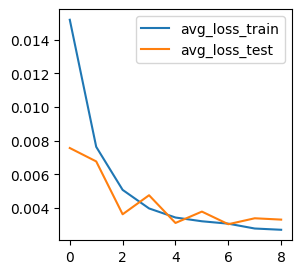

In [27]:
history = loss["history"]
history.to_csv("history.csv")
history[["avg_loss_train", "avg_loss_test"]].plot()

In [28]:

from ml_utility_loss.loss_learning.estimator.pipeline import eval
#eval_loss = loss["eval_loss"]

batch_size = params["batch_size_low"] if "batch_size_low" in params else params["batch_size"]

eval_loss = eval(
    test_set, model,
    batch_size=batch_size,
)

In [29]:
import pandas as pd

metrics = pd.DataFrame(eval_loss["model_metrics"]).T
metrics.to_csv("eval.csv")
metrics

avg_g_cos_loss  avg_g_mag_loss  avg_loss  grad_duration  \
realtabformer        0.010088        0.034937  0.002533       8.234227   

               grad_mae  grad_mape  grad_rmse  mean_pred_loss  pred_duration  \
realtabformer  0.250839   6.304386   0.449138        0.000011       8.565301   

               pred_mae  pred_mape  pred_rmse  pred_std  std_loss  \
realtabformer  0.037618   0.120085   0.050332  0.096218  0.016874   

               total_duration  
realtabformer       16.799528

In [30]:
from ml_utility_loss.util import clear_memory
clear_memory()

In [31]:
#"""
from ml_utility_loss.loss_learning.estimator.process import pred, pred_2
from ml_utility_loss.util import stack_samples

#samples = test_set[list(range(len(test_set)))]
#y = {m: pred(model[m], s) for m, s in samples.items()}
y = pred_2(model, test_set, batch_size=batch_size)
#"""

Caching in ../../../../contraceptive/_cache_aug_test/realtabformer/all inf False
Caching in ../../../../contraceptive/_cache_bs_test/realtabformer/all inf False
Caching in ../../../../contraceptive/_cache_synth_test/realtabformer/all inf False


In [32]:
import os
import pandas as pd
from ml_utility_loss.util import transpose_dict

os.makedirs("pred", exist_ok=True)
y2 = transpose_dict(y)
for k, v in y2.items():
    df = pd.DataFrame(v)
    df.to_csv(f"pred/{k}.csv")

In [33]:
print({k: sum(v["pred"])/len(v["pred"]) for k, v in y.items()})

{'realtabformer': 0.3862167485555013}


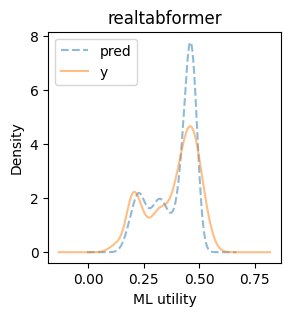

In [34]:
from ml_utility_loss.loss_learning.visualization import plot_pred_density_2

_ = plot_pred_density_2(y)

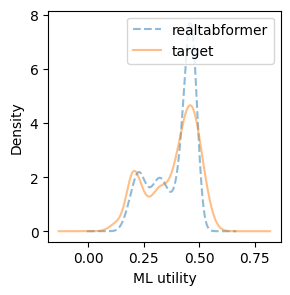

In [35]:
from ml_utility_loss.loss_learning.visualization import plot_density_3

_ = plot_density_3(y2["pred"], next(iter(y2["y"].values())))

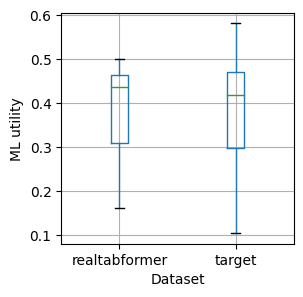

In [36]:
from ml_utility_loss.loss_learning.visualization import plot_box_3

_ = plot_box_3(y2["pred"], next(iter(y2["y"].values())))

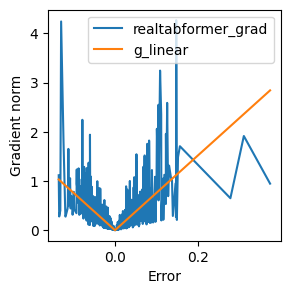

In [37]:
#"""
from ml_utility_loss.loss_learning.visualization import plot_grad, plot_grad_2, plot_grad_3
import matplotlib.pyplot as plt

#plot_grad_2(y, model.models)
for m in model.models:
    ym = y[m]
    fig, ax = plt.subplots()
    plot_grad_3(ym["error"], ym["grad"], name=f"{m}_grad", fig=fig, ax=ax)
#"""